# CamVid (Cambridge-Driving Labeled Video Database)

## Description
The Cambridge-driving Labeled Video Database (CamVid) provides ground truth labels that associate each pixel with one of 32 semantic classes. This dataset is often used in (real-time) semantic segmentation research.

The dataset is split up as follows:

* 367 training pairs
* 101 validation pairs
* 233 test pairs

The images and masks for each split are in a separate directory.

Citations:

[1] Brostow, Shotton, Fauqueur, Cipolla. **Segmentation and Recognition Using Structure from Motion Point Clouds**, 
_European Conference on Computer Vision (ECCV)_, 2008.

[2] Brostow, Fauqueur, Cipolla. **Semantic Object Classes in Video: A High-Definition Ground Truth Database**, 
_Pattern Recognition Letters_.

The original dataset can be found here:
http://mi.eng.cam.ac.uk/research/projects/VideoRec/CamVid

Source / Contact:
http://mi.eng.cam.ac.uk/research/projects/VideoRec/CamVid

Kaggle Source:
https://www.kaggle.com/datasets/carlolepelaars/camvid

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import tarfile 
import pandas as pd
import os
import numpy as np
import seaborn as sns

from sklearn.model_selection import StratifiedKFold, train_test_split

In [2]:
# Initialize notebook constants/config class
class CFG():
    RANDOM_SEED=42
    IMG_HEIGHT=256
    IMG_WIDTH=256
    BATCH_SIZE=16

In [3]:
files_path = "../input/camvid/CamVid/"

In [4]:
unique_classes = pd.read_csv(files_path + "class_dict.csv")
unique_classes.head()

,name,r,g,b
0,Animal,64,128,64
1,Archway,192,0,128
2,Bicyclist,0,128,192
3,Bridge,0,128,64
4,Building,128,0,0


In [5]:
color_map = unique_classes.drop("name", axis=1)
color_map_tf = tf.constant(color_map, dtype=tf.int32)

In [6]:
train_files = tf.data.Dataset.list_files(files_path + "train/*.png") 
val_files = tf.data.Dataset.list_files(files_path + "val/*.png") 

In [7]:
def rgb_class_convert(label_rgb, color_map, inverse=False):

    if not inverse:
        label_expanded = tf.expand_dims(label_rgb, axis=-2)  # [H, W, 1, 3]
        color_map_expanded = tf.reshape(color_map, [1, 1, -1, 3])  # [1, 1, N, 3]
        matches = tf.reduce_all(tf.equal(label_expanded, color_map_expanded), axis=-1)  # [H, W, num_classes]
        class_indices = tf.argmax(tf.cast(matches, tf.int32), axis=-1)
    else:
        label_indices = tf.argmax(label_rgb, axis=-1)
        rgb_image = tf.gather(color_map, label_indices)
        class_indices = rgb_image

    return class_indices

In [8]:
@tf.function
def load_image(img_path: tf.Tensor, ds_type: str):
    
    image_bytes = tf.io.read_file(img_path)
    image = tf.image.decode_png(image_bytes, channels=3)
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize(image, (CFG.IMG_HEIGHT, CFG.IMG_WIDTH))
    image_file = tf.strings.split(tf.strings.split(img_path, os.sep)[-1], ".")[0]

    if ds_type == "train":
        label_path = tf.strings.join([files_path, "train_labels/", image_file, "_L.png"])
    elif ds_type == "val":
        label_path = tf.strings.join([files_path, "val_labels/", image_file, "_L.png"])
    else:
        label_path = tf.strings.join([files_path, "test_labels/", image_file, "_L.png"])

    label = tf.io.read_file(label_path)
    label = tf.image.decode_png(label, channels=3)
    label = tf.image.resize(label, (CFG.IMG_HEIGHT, CFG.IMG_WIDTH), method = tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    label = tf.cast(label, tf.int32)
    label = rgb_class_convert(label, color_map_tf)
    label = tf.one_hot(label, depth=len(unique_classes))
    label = tf.cast(label, tf.float32)
        
    return image, label

In [9]:
def configure_performance(ds, is_train_ds: bool):
    if is_train_ds:
        ds = ds.cache()
        ds = ds.shuffle(100)
        ds = ds.batch(CFG.BATCH_SIZE)
        ds = ds.prefetch(tf.data.AUTOTUNE)
    else:            
        ds = ds.cache()
        ds = ds.batch(CFG.BATCH_SIZE)
        ds = ds.prefetch(tf.data.AUTOTUNE)
    return ds

In [30]:
def display_imgs(display_list, unique_classes, show_classes=True):
    
    display_list = list(display_list)
    display_list.insert(1, rgb_class_convert(display_list[1], color_map_tf, inverse=True)) # Inverse Transformed to color scale
    if len(display_list) > 3:
        display_list[-1] = tf.expand_dims(tf.argmax(display_list[-1], axis=-1), axis=-1)
        display_list[-2] = tf.expand_dims(tf.argmax(display_list[-2], axis=-1), axis=-1)
    else:
        display_list[-1] = tf.expand_dims(tf.argmax(display_list[-1], axis=-1), axis=-1)

    num_images = len(display_list)
    fig, axes = plt.subplots(1, num_images, figsize=(14, 10))
    
    titles = ['Input Image', 'True Mask', 'Class-indexed Mask', 'Predicted Mask']
    
    for ax, image, title in zip(axes, display_list, titles):
        ax.set_title(title)
        ax.imshow(tf.keras.utils.array_to_img(image))
        ax.axis('off')

    if show_classes:
        mask_tensor = display_list[2]
        mask_np = mask_tensor.numpy()
        unique_ids = np.unique(mask_np)
        unique_classes_filtered = unique_classes.iloc[unique_ids]
        
        handles = []
        for _, row in unique_classes_filtered.iterrows():
            label = f"{row['name']}"
            color_float = (row['r'] / 255.0, row['g'] / 255.0, row['b'] / 255.0)
            patch = mpatches.Patch(color=color_float, label=label)
            handles.append(patch)
        
        max_cols = 5
        ncols = min(len(handles), max_cols)   
        fig.legend(handles=handles,
                   title="True Mask Classes Colors (only)",
                   loc='lower center',
                   bbox_to_anchor=(0.5, 0.2),
                   ncol=ncols,
                   borderaxespad=0.)
        
    plt.show()

In [11]:
train_ds = train_files.map(lambda img_path: load_image(img_path, ds_type="train"), num_parallel_calls=tf.data.experimental.AUTOTUNE)
val_ds = val_files.map(lambda img_path: load_image(img_path, ds_type="val"), num_parallel_calls=tf.data.experimental.AUTOTUNE)

In [12]:
sample_img, sample_label = next(iter(train_ds))

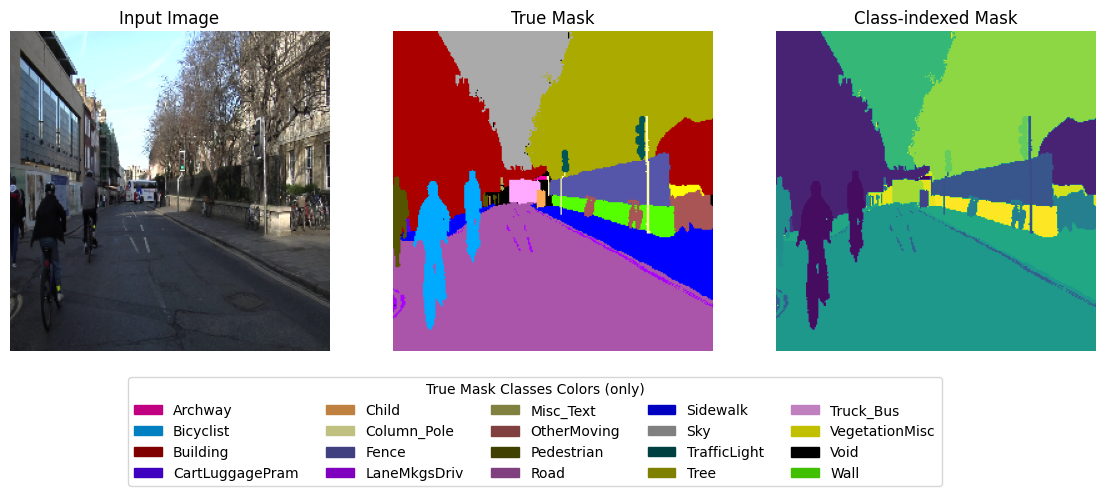

In [13]:
display_imgs([sample_img, sample_label], unique_classes)

In [14]:
train_ds = configure_performance(train_ds, is_train_ds=True)
val_ds = configure_performance(val_ds, is_train_ds=False)

# Define U-Net with MobileNetV2 Pretrained Model

In [15]:
# References for Conv2DTranspose and VGG16 model
# (1): https://www.tensorflow.org/api_docs/python/tf/keras/applications/MobileNetV2
# (2): https://www.tensorflow.org/tutorials/images/segmentation
# (3): https://keras.io/api/applications/mobilenet/

def unet_mobilenetv2(input_shape=(CFG.IMG_HEIGHT, CFG.IMG_WIDTH, 3), num_classes=None):

    base_model = tf.keras.applications.MobileNetV2(
        input_shape=input_shape,
        include_top=False,
        weights='imagenet'
    )
    
    layer_names = [
        'block_1_expand_relu',   
        'block_3_expand_relu', 
        'block_6_expand_relu',
        'block_13_expand_relu', 
        'block_16_project' 
    ]
    
    layers_outputs = [base_model.get_layer(name).output for name in layer_names]
    encoder = tf.keras.Model(inputs=base_model.input, outputs=layers_outputs)
    encoder.trainable = False
    
    inputs = tf.keras.Input(shape=input_shape)
    skips = encoder(inputs)
    
    x = skips[-1]
    decoder_filters = [512, 256, 128, 64]
    
    for i in range(1, len(skips)):
        x = tf.keras.layers.Conv2DTranspose(decoder_filters[i-1], kernel_size=3, strides=2, padding='same', activation='relu')(x)
        skip_connection = skips[-(i+1)]
        x = tf.keras.layers.Concatenate()([x, skip_connection])
        x = tf.keras.layers.Conv2D(decoder_filters[i-1], kernel_size=3, padding='same', activation='relu')(x)
        x = tf.keras.layers.Conv2D(decoder_filters[i-1], kernel_size=3, padding='same', activation='relu')(x)
    
    x = tf.keras.layers.Conv2DTranspose(32, kernel_size=3, strides=2, padding='same', activation='relu')(x)
    x = tf.keras.layers.Conv2D(32, kernel_size=3, padding='same', activation='relu')(x)
    x = tf.keras.layers.Conv2D(32, kernel_size=3, padding='same', activation='relu')(x)
    
    outputs = tf.keras.layers.Conv2D(num_classes, kernel_size=1, activation='softmax')(x)
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    return model


In [16]:
# Build and display the model summary.
model = unet_mobilenetv2(input_shape=(CFG.IMG_HEIGHT, CFG.IMG_WIDTH, 3), num_classes=len(unique_classes))
model.summary()

<ipython-input-15-cb044e7d5867>:8: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = tf.keras.applications.MobileNetV2(


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 256, 256, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ functional (Functional)   │ [(None, 128, 128, 96), │      1,841,984 │ input_layer_1[0][0]    │
│                           │ (None, 64, 64, 144),   │                │                        │
│                           │ (None, 32, 32, 192),   │                │                        │
│                           │ (None, 16, 16, 576),   │                │                        │
│                           │ (None, 8, 8, 320)]     │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_transpose          │ (None, 16, 16, 512)    │      1,475,072 │ functional[0][4]       │
│ (Conv2DTranspose)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 16, 16, 1088)   │              0 │ conv2d_transpose[0][0… │
│                           │                        │                │ functional[0][3]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 16, 16, 512)    │      5,014,016 │ concatenate[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 16, 16, 512)    │      2,359,808 │ conv2d[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_transpose_1        │ (None, 32, 32, 256)    │      1,179,904 │ conv2d_1[0][0]         │
│ (Conv2DTranspose)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_1             │ (None, 32, 32, 448)    │              0 │ conv2d_transpose_1[0]… │
│ (Concatenate)             │                        │                │ functional[0][2]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 32, 32, 256)    │      1,032,448 │ concatenate_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 32, 32, 256)    │        590,080 │ conv2d_2[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_transpose_2        │ (None, 64, 64, 128)    │        295,040 │ conv2d_3[0][0]         │
│ (Conv2DTranspose)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_2             │ (None, 64, 64, 272)    │              0 │ conv2d_transpose_2[0]… │
│ (Concatenate)             │                        │                │ functional[0][1]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 64, 64, 128)    │        313,472 │ concatenate_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)         │ (None, 64, 64, 128)    │        147,584 │ conv2d_4[0][0]         │
├──────────────────────

 Total params: 14,490,368 (55.28 MB)

 Trainable params: 12,648,384 (48.25 MB)

 Non-trainable params: 1,841,984 (7.03 MB)

In [17]:
def dice_loss(y_true, y_pred, smooth=1e-6):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    
    intersection = tf.reduce_sum(y_true * y_pred, axis=[1,2])
    union = tf.reduce_sum(y_true, axis=[1,2]) + tf.reduce_sum(y_pred, axis=[1,2])
    dice = (2 * intersection + smooth) / (union + smooth) # multiply by two because of union divider
    
    return 1 - tf.reduce_mean(dice) 

In [18]:
def total_loss(y_true, y_pred):
    ce = tf.keras.losses.categorical_crossentropy(y_true, y_pred)
    dice = dice_loss(y_true, y_pred)
    return ce + dice

In [22]:
EPOCHS = 25

##approx calculation
train_steps= int((len(train_files) / CFG.BATCH_SIZE) * EPOCHS)
warmup_steps=int(train_steps * 0.1)
decay_steps=train_steps - warmup_steps

lr_schedule = tf.keras.optimizers.schedules.CosineDecay(
    initial_learning_rate=1e-5,
    warmup_target=0.001,
    warmup_steps=warmup_steps,
    decay_steps=decay_steps,
    alpha=0.0
)

In [23]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(lr_schedule),
    loss=total_loss,
    metrics=['accuracy']
)

In [24]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
)

Epoch 1/25
24/24 ━━━━━━━━━━━━━━━━━━━━ 61s 1s/step - accuracy: 0.1774 - loss: 4.1914 - val_accuracy: 0.2879 - val_loss: 3.3892
Epoch 2/25
24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 212ms/step - accuracy: 0.3546 - loss: 3.2627 - val_accuracy: 0.3742 - val_loss: 3.8212
Epoch 3/25
24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 209ms/step - accuracy: 0.4217 - loss: 2.9577 - val_accuracy: 0.5872 - val_loss: 2.3995
Epoch 4/25
24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 213ms/step - accuracy: 0.5868 - loss: 2.2927 - val_accuracy: 0.6554 - val_loss: 2.1397
Epoch 5/25
24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 212ms/step - accuracy: 0.6739 - loss: 2.0454 - val_accuracy: 0.6951 - val_loss: 2.0076
Epoch 6/25
24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 216ms/step - accuracy: 0.7215 - loss: 1.9080 - val_accuracy: 0.7577 - val_loss: 1.8146
Epoch 7/25
24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 211ms/step - accuracy: 0.7642 - loss: 1.7545 - val_accuracy: 0.7742 - val_loss: 1.7708
Epoch 8/25
24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 212ms/step - accuracy: 0.7850 - loss: 1.6768 - val_accuracy: 0.77

In [25]:
loss, accuracy = model.evaluate(val_ds)
print("Validation Loss:", loss)
print("Validation Accuracy:", accuracy)

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 95ms/step - accuracy: 0.8432 - loss: 1.4268 
Validation Loss: 1.3989596366882324
Validation Accuracy: 0.8487803936004639


In [26]:
predictions = model.predict(val_ds)

7/7 ━━━━━━━━━━━━━━━━━━━━ 6s 509ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


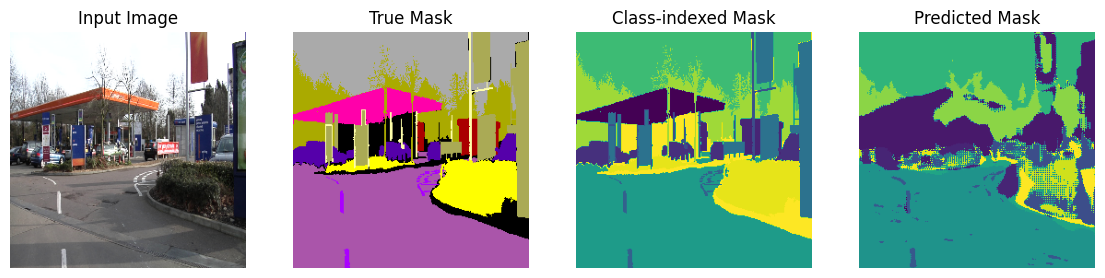

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


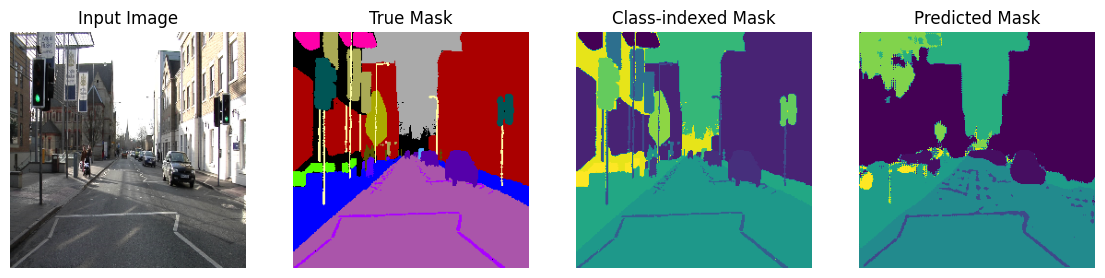

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


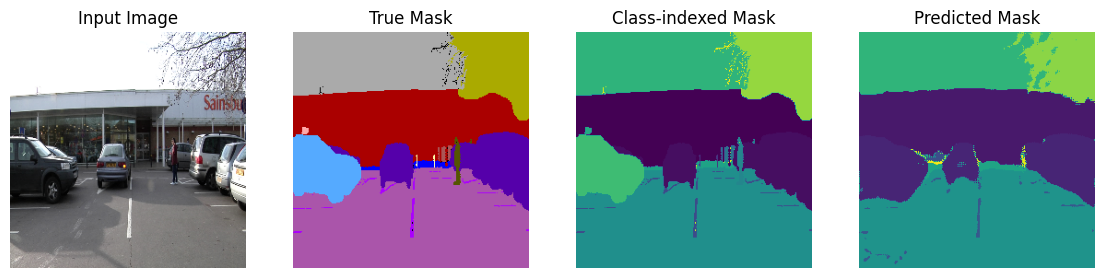

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


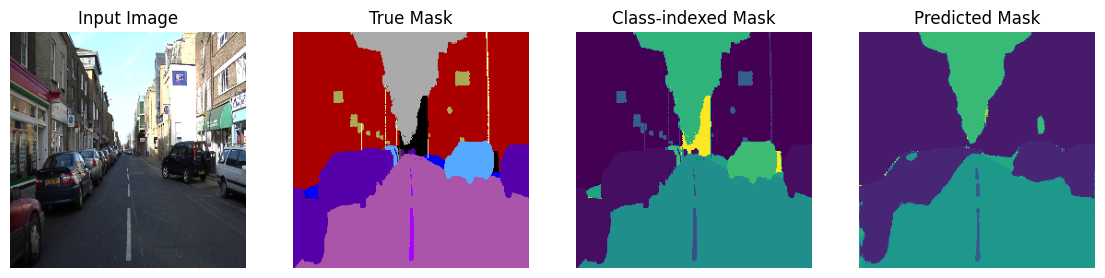

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


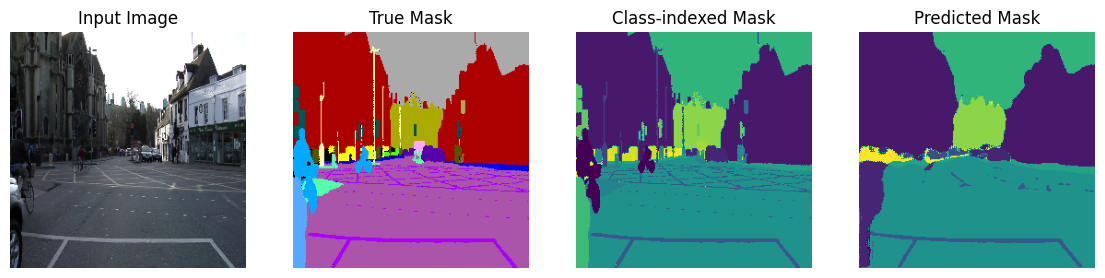

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


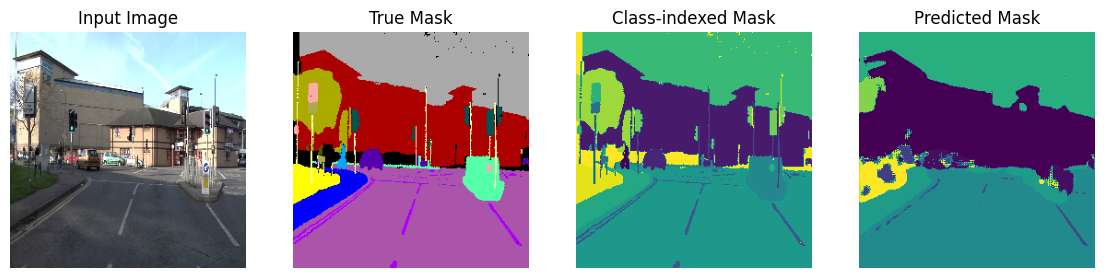

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


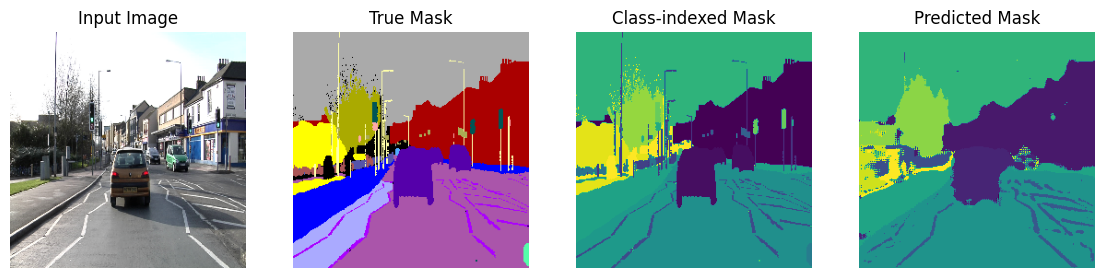

In [31]:
for samples in val_ds.take(10):
    sample_img = (samples[0][0], samples[1][0], model.predict(samples[0])[0])
    display_imgs(sample_img, unique_classes, show_classes=False)

In [32]:
labels_list = []

for x_batch, y_batch in val_ds:    
    labels_list.append(y_batch.numpy())

labels = np.concatenate(labels_list, axis=0)

In [33]:
pred_class = tf.argmax(predictions, axis=-1) 
true_class = tf.argmax(labels, axis=-1)

pred_class = pred_class.numpy()
true_class = true_class.numpy()

In [34]:
num_classes = len(unique_classes)
pred_class_flat = pred_class.reshape(-1)
true_class_flat = true_class.reshape(-1)

conf_mat_tf = tf.math.confusion_matrix(true_class_flat, pred_class_flat, num_classes=num_classes)
conf_mat_norm =  conf_mat_tf / tf.reduce_sum(conf_mat_tf, axis=1, keepdims=True)
conf_mat = conf_mat_tf.numpy()

In [35]:
sum_over_rows = np.sum(conf_mat, axis=0)
sum_over_cols = np.sum(conf_mat, axis=1)
diag = np.diag(conf_mat)
denominator = sum_over_rows + sum_over_cols - diag
iou_per_class = diag / (denominator + 1e-7)
mean_iou = np.mean(iou_per_class)

pixel_accuracy = np.sum(diag) / np.sum(conf_mat)

print("IoU per class:", iou_per_class)
print("Mean IoU:", mean_iou)
print("Pixel-wise Accuracy:", pixel_accuracy)

IoU per class: [0.00000000e+00 0.00000000e+00 4.17507183e-02 0.00000000e+00
 8.08408098e-01 6.26472219e-01 0.00000000e+00 0.00000000e+00
 9.50210744e-03 2.88324672e-01 4.70679957e-01 0.00000000e+00
 2.02439395e-04 0.00000000e+00 5.16763980e-02 4.27585364e-04
 9.98751561e-05 9.03617667e-01 0.00000000e+00 7.57521186e-01
 0.00000000e+00 9.03353475e-01 7.24493054e-03 0.00000000e+00
 1.79333596e-03 0.00000000e+00 7.51114151e-01 0.00000000e+00
 0.00000000e+00 1.32508005e-01 1.18454752e-01 3.35110817e-01]
Mean IoU: 0.19400819966281121
Pixel-wise Accuracy: 0.8487806701660157


/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


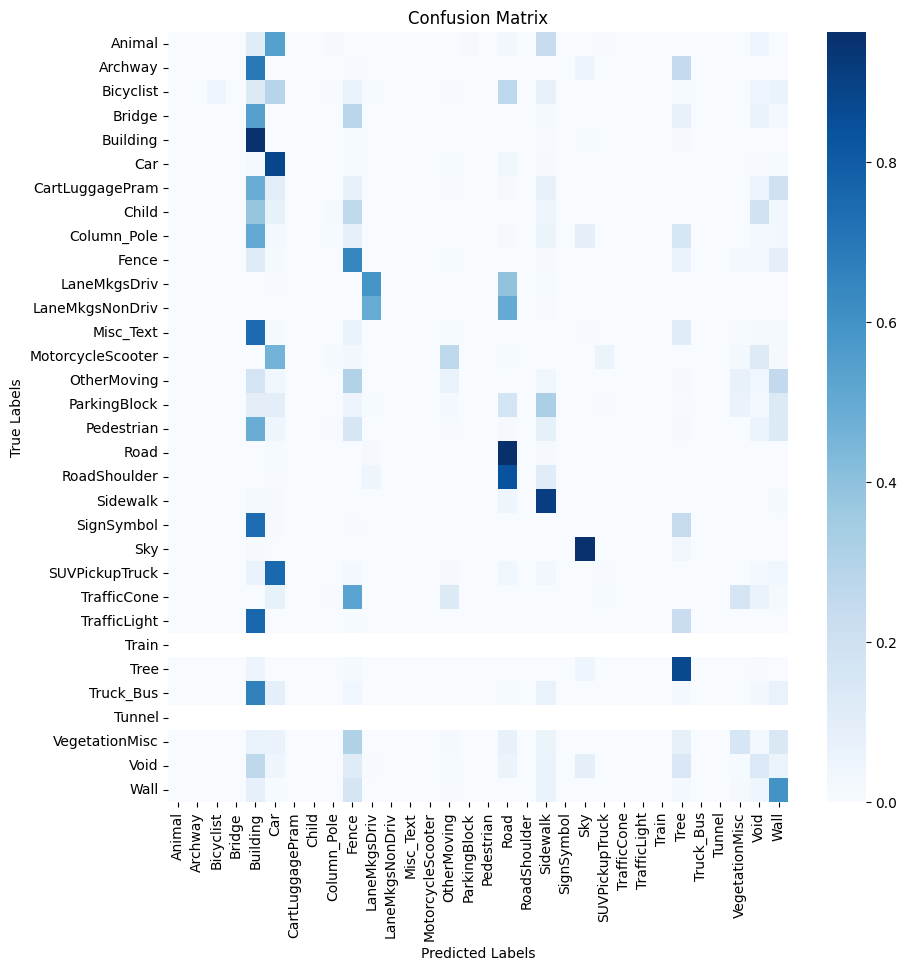

In [39]:
class_names = unique_classes.name.to_list()

plt.figure(figsize=(10, 10))
sns.heatmap(
    conf_mat_norm, 
    annot=False, 
    fmt='.4f', 
    cmap='Blues', 
    xticklabels=class_names, 
    yticklabels=class_names,
)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()